   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

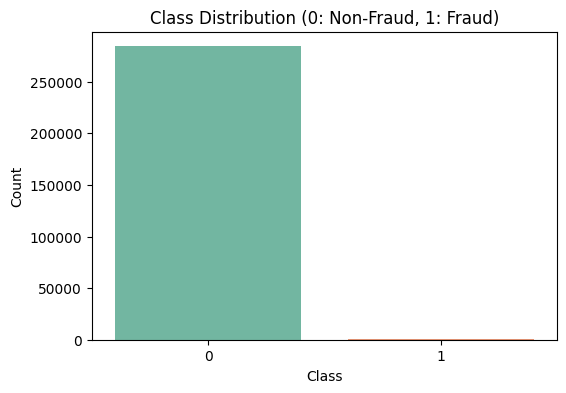

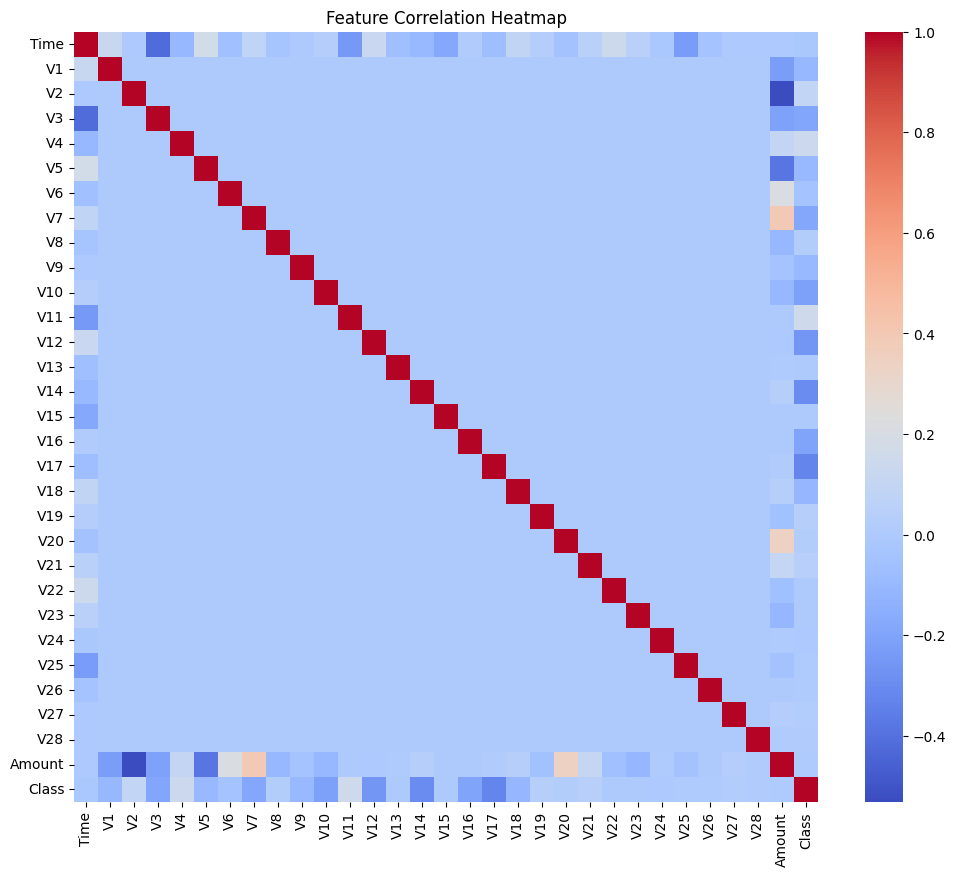

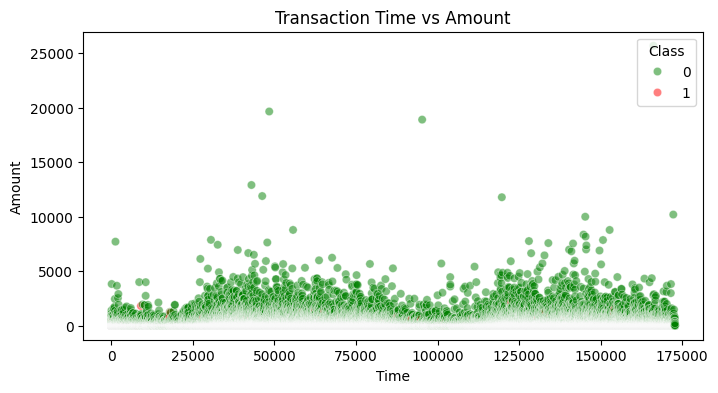


--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     85149
           1       0.97      0.92      0.95     85440

    accuracy                           0.95    170589
   macro avg       0.95      0.95      0.95    170589
weighted avg       0.95      0.95      0.95    170589



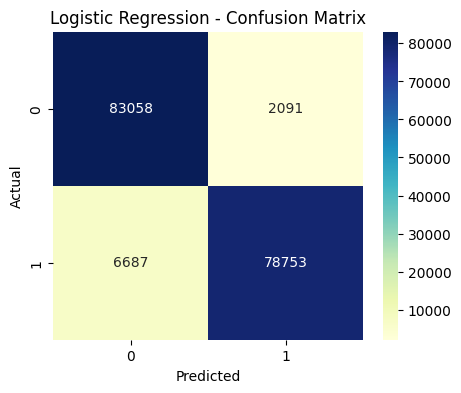

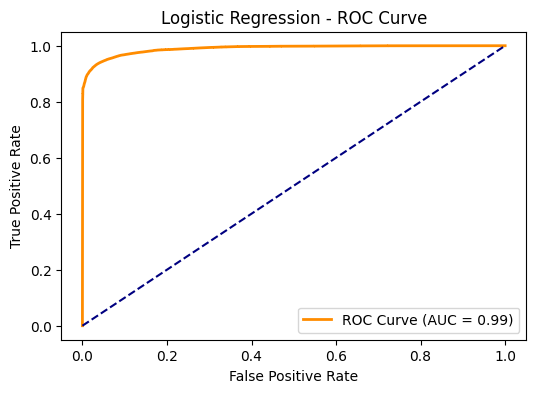


--- Random Forest Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



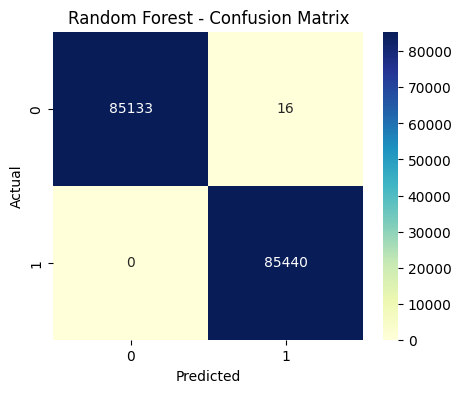

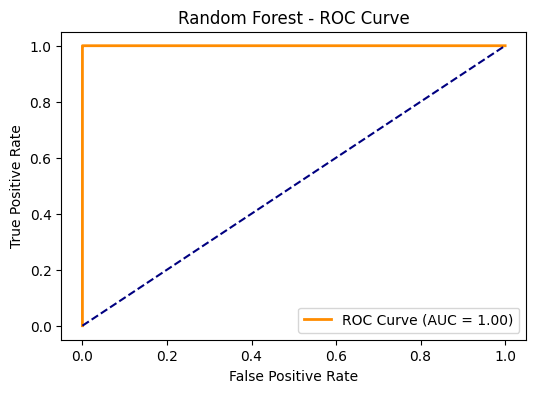


--- XGBoost Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



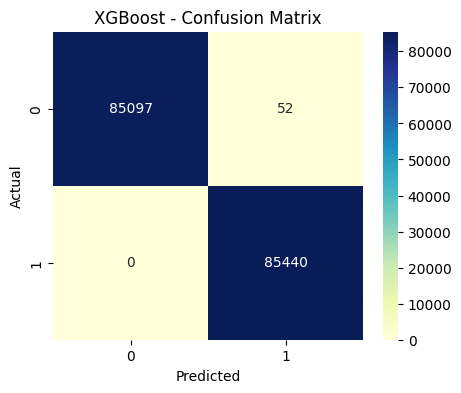

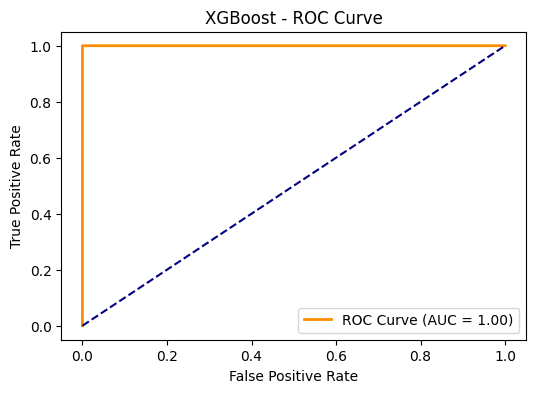

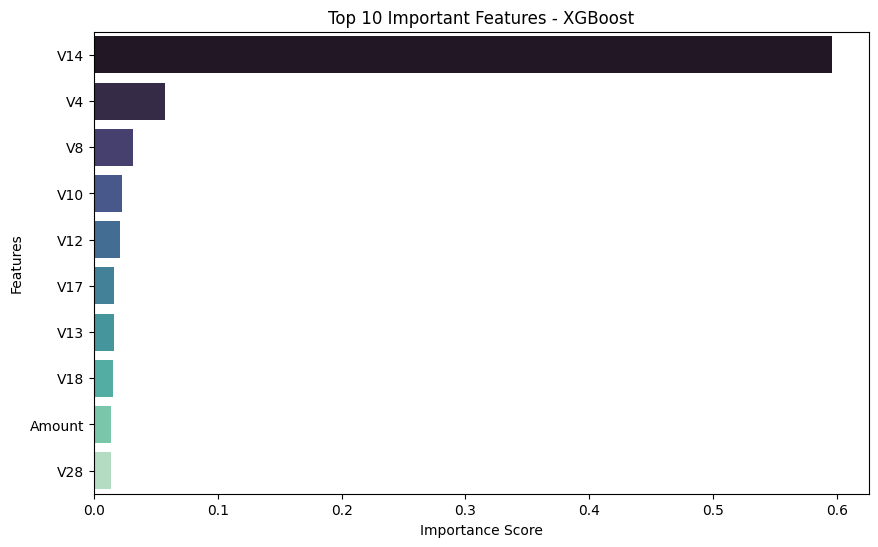

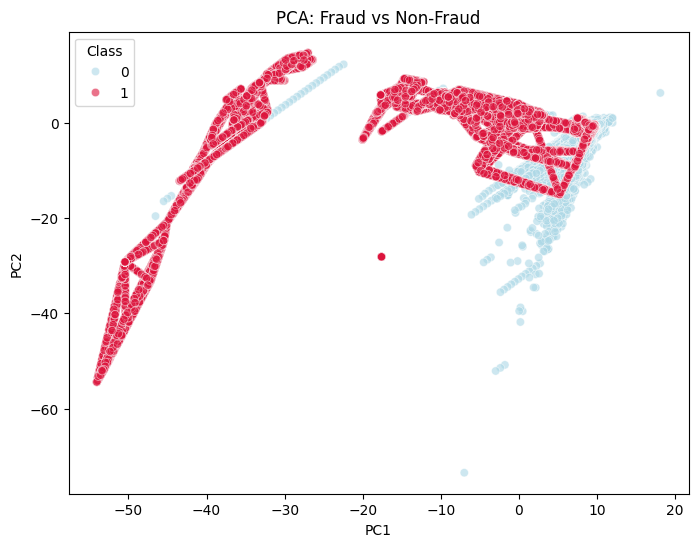

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# 1. Load Dataset
df = pd.read_csv('/content/creditcard.csv')
print(df.head())

# 2. Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# 3. Visualize Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df, palette='Set2')
plt.title("Class Distribution (0: Non-Fraud, 1: Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# 4. Correlation Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# 5. Scatter Plot: Time vs Amount
plt.figure(figsize=(8,4))
sns.scatterplot(data=df, x='Time', y='Amount', hue='Class', palette=['green', 'red'], alpha=0.5)
plt.title("Transaction Time vs Amount")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.legend(title="Class", loc="upper right")
plt.show()

# 6. Feature Scaling
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])
df['Time'] = scaler.fit_transform(df[['Time']])

# 7. Feature/Target Split
X = df.drop('Class', axis=1)
y = df['Class']

# 8. Apply SMOTE to balance the dataset
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)

# 9. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 10. Function: Model Evaluation with Visuals
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(f"\n--- {name} Report ---")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# 11. Logistic Regression
evaluate_model(LogisticRegression(max_iter=1000), "Logistic Regression")

# 12. Random Forest
evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest")

# 13. XGBoost Classifier
evaluate_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), "XGBoost")

# 14. Feature Importance (XGBoost)
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train, y_train)
importances = model_xgb.feature_importances_
indices = importances.argsort()[::-1]
features = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices][:10], y=features[indices][:10], palette='mako')
plt.title("Top 10 Important Features - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# 15. PCA Scatterplot for Visualization (Optional)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Class'] = y_resampled

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Class', palette={0: "lightblue", 1: "crimson"}, alpha=0.6)
plt.title("PCA: Fraud vs Non-Fraud")
plt.show()
